# IFT712 Projet Fin de Session

------------------------------
MAHDI AIT LHAJ LOUTFI (aitm2302)  
YOVAN TURCOTTE (tury1903)



## Visualisation des données et analyse des résultats :
Dans ce Notebook, on va analyse les resultas de l'entrainement. Dans le fond on va choisir le modele avec la meilleur performance, et le tester sur les donnees de test.

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
#-------for Pre-Processing----
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from src.DataProcesser.Processer import DataProcesser
#------------------------------
import src.Manager
from sklearn.metrics import confusion_matrix
import seaborn as sns
%reload_ext autoreload
%autoreload 2


## Charger les données :
Si la cellule suivante marche, ca veut dire que l'extraction des données marche tres bien.

In [3]:
DP = DataProcesser(seed = 16082604)
DP.importData(label_name = 'species')
print(f"The total dataset has {DP.df().shape[0]} observations with dimentionality {DP.df().shape[1]}.")
DP.df().head()

The total dataset has 990 observations with dimentionality 192.


,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
3,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
5,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
6,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


## Organisation et distribution des données :
1- On va premierement diviser les données d'entrainement,test et validation

2- Faire un Sanity Check


In [4]:
DP.split_data(test_ratio = 0.1)
print("Train + Validation dataset created")

Train + Validation dataset created


In [5]:
#Sanity Check
#Verifier que toutes les classes du test set figurent dans les train + validation sets
Diff = set(DP.labels_Test()) - set(DP.labels_Train()) #should be empty set
if(Diff == set()):
    print("Sanity Check Verified!")
else:
    print("Sanity Check Verification Failed!")
    raise ValueError("There are no training observations for the classes : "+ str(Diff))

Sanity Check Verified!


## Chargement de resultats

In [79]:
with open('../results/results.json') as f:
    results = json.load(f)
print(f'There are {len(results)} different models.')

There are 5042 different models.


In [80]:
#Calculating FScore
for key in results:
    precision = np.float(results[key]['results']['Precision'])
    recall = np.float(results[key]['results']['Recall'])
    if(recall == 0.0 or precision == 0.0):
        results[key]['results']['FScore'] = '0.000'
    else:
        results[key]['results']['FScore'] = str(2.0 / (1.0 / precision + 1.0 / recall))[:5]

<ipython-input-80-cc578c9384f3>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  precision = np.float(results[key]['results']['Precision'])
<ipython-input-80-cc578c9384f3>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  recall = np.float(results[key]['results']['Recall'])


## Chercher le meilleur modele pour chaque classifieur

In [81]:
# Unique Classifiers type
classifiers = set(map(lambda x: results[x]['pipeline']['ClassificationParams']['classifier'],results))

#Get results for each classifier
classifierResults = {classifier:[] for classifier in classifiers}
for result in results.values():
    classifier = result['pipeline']['ClassificationParams']['classifier']
    classifierResults[classifier].append(result)
    
print('The classifier types are:', classifiers)

The classifier types are: {'LogisticRegressionModel', 'KernelModel', 'GenerativeModel'}


In [82]:
# For each classifier type, sort by best results
sortedClassifiersBestAccuracy = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Accuracy'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestRecall   = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Recall'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestPrecision= {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['Precision'],
                                                    reverse = True )[0] for classifier in classifiers}
sortedClassifiersBestFScore   = {classifier:sorted( classifierResults[classifier], 
                                                    key = lambda x: x['results']['FScore'],
                                                    reverse = True )[0] for classifier in classifiers}

In [83]:
def pprintBestResults(bestModels,metric):
    """
    Method that will nicely display the results
    
    
    bestModels: best model for each classifier type
    metric: str of Metric to be used.
    """
    classifiers = set(bestModels)
    DataManagerParams    = {classifier:bestModels[classifier]['pipeline']['DataPreProcessingParams']['cases'] 
                                                                                     for classifier in classifiers}
    ClassificationParams = {classifier:bestModels[classifier]['pipeline']['ClassificationParams'] 
                                                                                     for classifier in classifiers}
    metricResults = {classifier:bestModels[classifier]['results'][metric] for classifier in classifiers} 
          
    columns = ['PreProcessing1', 'PreProcessing2', 'Hyperparams', metric]
    df = pd.DataFrame(np.full((len(classifiers), 4), np.nan), columns = columns, index = classifiers)
    for classifier in sorted(metricResults,key = lambda x: metricResults[x], reverse = True):
        out = f"For {classifier}, the model with the best {metric} of {metricResults[classifier]}\n\thas hyperparameters: "
        hyperparams = ClassificationParams[classifier] .copy()
        del hyperparams['classifier']
        hyperparams = [f'{hp}={str(hyperparams[hp])[:5]}' for hp in hyperparams]
        preprocessing = [preprocess['method'] for preprocess in DataManagerParams[classifier]]
        
        
        df.loc[classifier] = np.array([preprocessing[0],preprocessing[1],hyperparams,metricResults[classifier] ],dtype=object)
        df.sort_values(metric,axis=0, inplace=True, ascending = False)
    
    #Printing
    print('RESULTS')
    print(df.drop('Hyperparams',axis=1).head())
    print('\nHYPERPARAMS')
    print(df['Hyperparams'])

### Accuracy

In [84]:
pprintBestResults(sortedClassifiersBestAccuracy, 'Accuracy')

RESULTS
                         PreProcessing1 PreProcessing2 Accuracy
KernelModel              StandardScaler  LDA            0.984  
LogisticRegressionModel  Normalize       LDA            0.978  
GenerativeModel          StandardScaler  LDA            0.811  

HYPERPARAMS
KernelModel                [alpha=1e-09, kernel=rbf, gamma=0.002]                        
LogisticRegressionModel    [solver=libli, random_state=0, penalty=l2, tol=0.000, C=78.47]
GenerativeModel            []                                                            
Name: Hyperparams, dtype: object


### Precision

In [90]:
pprintBestResults(sortedClassifiersBestPrecision, 'Precision')

RESULTS
                         PreProcessing1 PreProcessing2 Precision
KernelModel              Normalize       LDA            0.986   
LogisticRegressionModel  Normalize       LDA            0.979   
GenerativeModel          StandardScaler  LDA            0.893   

HYPERPARAMS
KernelModel                [alpha=0.022, kernel=rbf, gamma=0.067]                        
LogisticRegressionModel    [solver=libli, random_state=0, penalty=l2, tol=0.000, C=78.47]
GenerativeModel            []                                                            
Name: Hyperparams, dtype: object


### Recall

In [91]:
pprintBestResults(sortedClassifiersBestRecall, 'Recall')

RESULTS
                         PreProcessing1 PreProcessing2 Recall
KernelModel              Normalize       LDA            0.984
LogisticRegressionModel  Normalize       LDA            0.977
GenerativeModel          StandardScaler  LDA            0.779

HYPERPARAMS
KernelModel                [alpha=0.000, kernel=rbf, gamma=0.007]                        
LogisticRegressionModel    [solver=libli, random_state=0, penalty=l2, tol=0.000, C=78.47]
GenerativeModel            []                                                            
Name: Hyperparams, dtype: object


### F1Score

In [92]:
pprintBestResults(sortedClassifiersBestFScore, 'FScore')

RESULTS
                         PreProcessing1 PreProcessing2 FScore
KernelModel              Normalize       LDA            0.984
LogisticRegressionModel  Normalize       LDA            0.977
GenerativeModel          StandardScaler  LDA            0.832

HYPERPARAMS
KernelModel                [alpha=0.000, kernel=rbf, gamma=0.007]                        
LogisticRegressionModel    [solver=libli, random_state=0, penalty=l2, tol=0.000, C=78.47]
GenerativeModel            []                                                            
Name: Hyperparams, dtype: object


### Modèle finale choisie :
Classifier: SVM  
Hyperparameters:  
C=1.623,
kernel=linear,
degree=2,
gamma=1e-09  


In [88]:
sortedClassifiersBestFScore['KernelModel']

{'pipeline': {'DataPreProcessingParams': {'seed': 16082604,
   'cases': [{'method': 'Normalize', 'hyperparams': {}},
    {'method': 'LDA', 'hyperparams': {'n_components': 100}}]},
  'ClassificationParams': {'classifier': 'KernelModel',
   'alpha': 0.00024255310558892541,
   'kernel': 'rbf',
   'gamma': 0.0071349432492320355},
  'StatisticsParams': ['Accuracy', 'Precision', 'Recall']},
 'results': {'Accuracy': '0.984',
  'Precision': '0.985',
  'Recall': '0.984',
  'FScore': '0.984'}}

## Results sur le Test Set
For the best F-Score result of each classifier type, we will be running on the test set and printing the results

In [89]:
testSetResultsClassifiers = {}
for classifier in classifiers:
    testSetResults = src.Manager.runTestSet(**sortedClassifiersBestFScore[classifier]['pipeline'])
    precision = float(testSetResults['metrics']['Precision'])
    recall = float(testSetResults['metrics']['Recall'])
    if(recall == 0.0 or precision == 0.0):
        testSetResults['metrics']['FScore'] = 0.0
    else:
        testSetResults['metrics']['FScore'] = str(2.0 / (1.0 / precision + 1.0 / recall))[:5]
    testSetResultsClassifiers[classifier] = testSetResults

#Printing sorted results
resultsTestSet = pd.DataFrame(np.zeros((3, 4)), columns = ['Accuracy','Precision','Recall','FScore'],index = classifiers)
for classifier in sorted(testSetResultsClassifiers, key = lambda x:testSetResultsClassifiers[x]['metrics']['FScore'],reverse = True): 
    for metric in testSetResultsClassifiers[classifier]['metrics']:
        resultsTestSet.loc[classifier][metric] = testSetResultsClassifiers[classifier]['metrics'][metric]
print(resultsTestSet.sort_values('FScore',axis=0,ascending = False))

                         Accuracy  Precision  Recall  FScore
LogisticRegressionModel  0.996     0.996      0.998   0.996 
KernelModel              0.992     0.986      0.985   0.985 
GenerativeModel          0.875     0.897      0.890   0.893 


Surprising! The Logistic Regression has a better FScore than SVM, which was our previous winner. This result is meaning less as the chosen model has to stem from the cross-validation results but it is still interesting. All being said, the 0.001 difference between the two models is statistically insignificant. 

## Confusion Matrix with SVM model

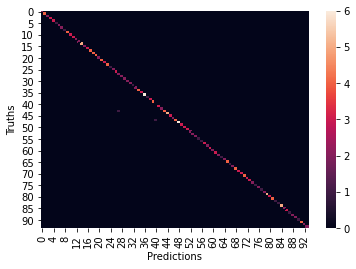

In [53]:
# Generating Confusion matrix
testSetResults = src.Manager.runTestSet(**sortedClassifiersBestFScore['KernelModel']['pipeline'])
predictions = testSetResults['predictions']
truths = testSetResults['truths']
sns.heatmap(confusion_matrix(truths,predictions))
plt.xlabel('Predictions')
plt.ylabel('Truths')
plt.show()

We get a very distinct straight diagonal, indicating we have good results. 

## Average results from preprocessing combination

Our team is curious to see if preprocessing differently changed anything in the performance. We will verify below.

In [54]:
def pprintPreprocessing(cmds):
    return "&".join([cmd['method'] for cmd in cmds])
preprocessCombinations = set(map(lambda x: pprintPreprocessing(results[x]['pipeline']['DataPreProcessingParams']['cases']), results))

#Attach all results to their preprocessing combination
preprocess = {combination:[] for combination in preprocessCombinations}
for trial in results:
    preprocess[pprintPreprocessing(results[trial]['pipeline']['DataPreProcessingParams']['cases'])].append(results[trial]['results'])
    
#Calculate average of metrics for every preprocess combination
preprocessAvg = {}
for combination in preprocessCombinations:
    avgDict = {}
    for metric in preprocess[combination][0].keys():
        avgDict[metric] = sum(float(d[metric]) for d in preprocess[combination]) / len(preprocess[combination])
    preprocessAvg[combination] = avgDict

In [55]:
def sortPreProcessingByMetric(metric):
    preprocessingSorted = sorted(preprocessAvg, key = lambda x: preprocessAvg[x][metric], reverse = True)
    out = pd.DataFrame([],columns = [metric], index = preprocessingSorted)
    for combination in preprocessingSorted:
        out.loc[combination] = preprocessAvg[combination][metric]
    print(out)

In [56]:
sortPreProcessingByMetric('Accuracy')

                                  Accuracy
StandardScaler&LDA                0.818932
StandardScaler&FeatureExtraction  0.760677
Normalize&LDA                     0.748855
Normalize&FeatureExtraction       0.679332


In [57]:
sortPreProcessingByMetric('Precision')

                                 Precision
StandardScaler&LDA                0.83118 
StandardScaler&FeatureExtraction  0.766371
Normalize&LDA                     0.755362
Normalize&FeatureExtraction       0.68694 


In [58]:
sortPreProcessingByMetric('Recall')

                                    Recall
StandardScaler&LDA                0.805459
StandardScaler&FeatureExtraction  0.744719
Normalize&LDA                     0.733687
Normalize&FeatureExtraction       0.661848


In [59]:
sortPreProcessingByMetric('FScore')

                                    FScore
StandardScaler&LDA                0.817264
StandardScaler&FeatureExtraction  0.754444
Normalize&LDA                     0.743331
Normalize&FeatureExtraction       0.673043


The StandardScaler & PCA (with num_components = 100) seems to be the best combination of preprocessing out of the 4 combinations.